# The code is to analysis the data stored in the PVData.

## suposed that the total training epoch needed is 1000.

In [1]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt

In [2]:
cur_dir = os.getcwd()
# find the parent directory
parent_dir = os.path.dirname(cur_dir)
print(f'The parent dir is: {parent_dir}')
# get the data folder
data_folder = os.path.join(parent_dir, 'PVData')
print(data_folder)  

The parent dir is: /Users/dtjgp/Projects/GreenAI/SolarPanelData
/Users/dtjgp/Projects/GreenAI/SolarPanelData/PVData


In [3]:
# show the files in the folder
files = os.listdir(data_folder)
print(files)
wdc_files = [f for f in files if 'wdc' in f]
wdc_files.sort()
print(wdc_files)

['pvwatts_4sqm_600wdc.csv', 'pvwatts_2sqm_300wdc.csv', 'pvwatts_6sqm_900wdc.csv', 'pvwatts_5sqm_800wdc.csv', 'pvwatts_1sqm_200wdc.csv', 'pvwatts_7sqm_1000wdc.csv', 'pvwatts_info.csv', 'pvwatts_1sqm_100wdc.csv', 'pvwatts_3sqm_400wdc.csv', 'pvwatts_3sqm_500wdc.csv', 'pvwatts_5sqm_700wdc.csv']
['pvwatts_1sqm_100wdc.csv', 'pvwatts_1sqm_200wdc.csv', 'pvwatts_2sqm_300wdc.csv', 'pvwatts_3sqm_400wdc.csv', 'pvwatts_3sqm_500wdc.csv', 'pvwatts_4sqm_600wdc.csv', 'pvwatts_5sqm_700wdc.csv', 'pvwatts_5sqm_800wdc.csv', 'pvwatts_6sqm_900wdc.csv', 'pvwatts_7sqm_1000wdc.csv']


In [4]:
# read the data
pvs = {f"pv{(i+1)*100}": pd.read_csv(os.path.join(data_folder, file)) 
    for i, file in enumerate(wdc_files)}
print(pvs.keys())

dict_keys(['pv100', 'pv200', 'pv300', 'pv400', 'pv500', 'pv600', 'pv700', 'pv800', 'pv900', 'pv1000'])


In [5]:
for key, value in pvs.items():
    # print(key)
    # for each value, only keep last 2 columns
    pvs[key] = value.iloc[:, -2:]
    # print(pvs[key].head())

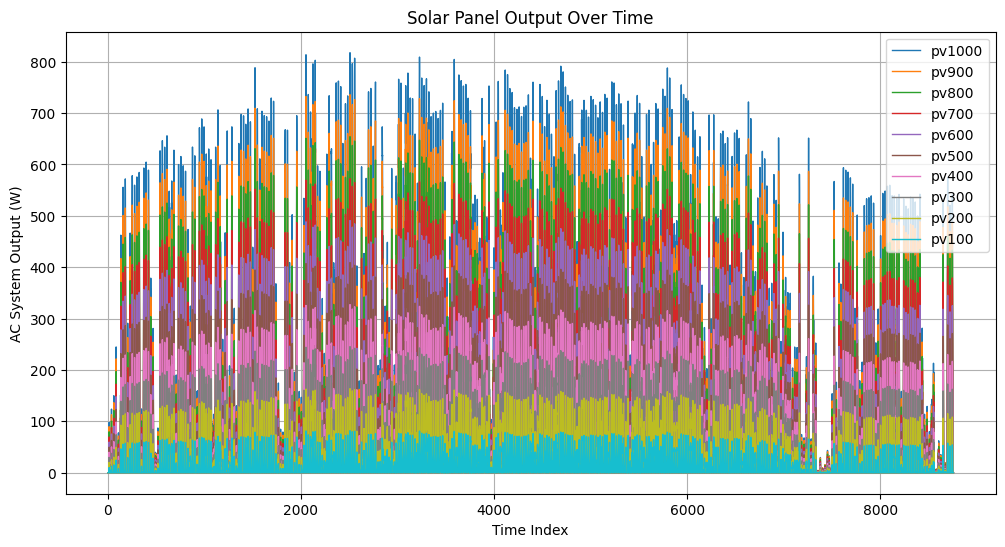

In [6]:
# plot the data use line graph, the x-axis is the index of the dataframe, the y-axis is the power output of the last column
plt.figure(figsize=(12, 6))
# Convert dictionary items to list and reverse it so smaller PVs are plotted last
items = list(pvs.items())
items.reverse()

for key, value in items:
    x = value.index
    y = value.iloc[:, 1]
    plt.plot(x, y, label=key, linewidth=1)

plt.xlabel('Time Index')
plt.ylabel('AC System Output (W)')
plt.title('Solar Panel Output Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# read the data_power_freq file
power_freq = pd.read_csv(os.path.join(cur_dir, 'data_power_freq.csv'))
# print(power_freq.head())
power_level = power_freq['power_level']
total_time = power_freq['total_time']
# the original data is the time needed for 5 epochs, so we need to divide it by 5 to get the time for 1 epoch
epoch_time = total_time / 5

# the time for 100 epochs
epoch100_time = epoch_time * 1000

# transfer the time to hours
epoch100_time = epoch100_time / 3600

print(power_level)
print(epoch100_time)

0     100
1     110
2     120
3     130
4     140
5     150
6     160
7     170
8     180
9     190
10    200
11    210
12    220
13    230
14    240
15    250
16    260
17    270
18    280
19    290
20    300
21    310
22    320
Name: power_level, dtype: int64
0     27.533898
1     23.618478
2     20.858999
3     18.547167
4     16.858736
5     15.652261
6     14.771526
7     14.389472
8     14.207615
9     14.080189
10    13.996445
11    13.918626
12    13.903725
13    13.817769
14    13.775942
15    13.758791
16    13.746575
17    13.749184
18    13.745442
19    13.664011
20    13.690003
21    13.690662
22    13.897535
Name: total_time, dtype: float64


### all the model was trained in the smallest power level.

In [8]:
running_list = np.zeros((len(pvs), len(pvs['pv100'])))
print(running_list.shape)
for key, value in pvs.items():
    # get the index of the key
    index = list(pvs.keys()).index(key)
    for i in range(len(value)):
        for j in power_level:
            solar_output = value.iloc[i, 1]
            if solar_output > j:
                # print(f'Solar output on hour {i} exceeded the power level {j}, and the system will run under this power level')
                running_list[index, i] = j
                break

(10, 8760)


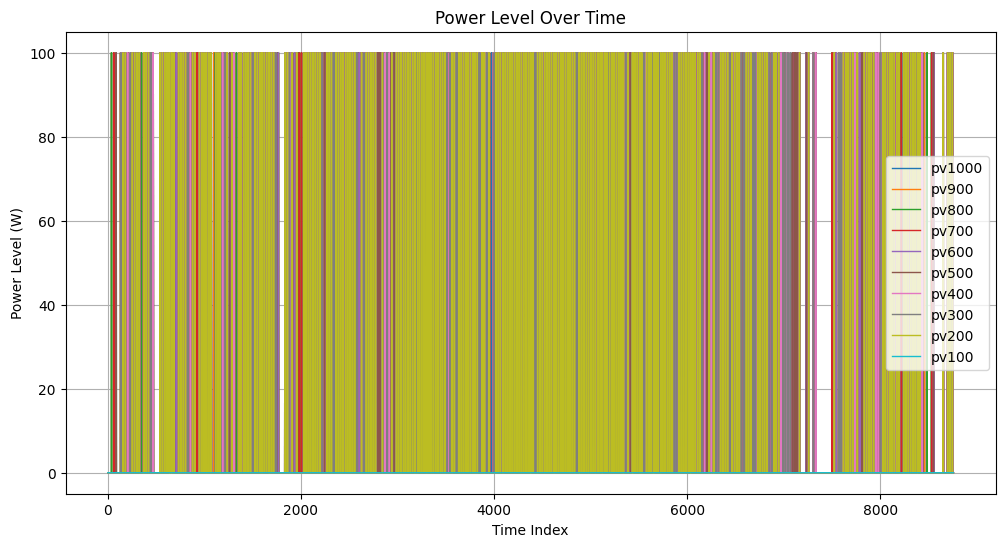

In [9]:
# plot the running list
plt.figure(figsize=(12, 6))
# Get all keys in correct order (smallest to largest)
keys = sorted(pvs.keys(), key=lambda x: int(x[2:]))
# Plot in reverse order so smaller PVs are on bottom
for i in range(len(running_list)-1, -1, -1):
    plt.plot(running_list[i], label=keys[i], linewidth=1)
    
plt.xlabel('Time Index')
plt.ylabel('Power Level (W)')
plt.title('Power Level Over Time')
plt.legend()
plt.grid(True)
plt.show()

### each time slot power is set to the highest power level that can be reached by the current power generated by the PV.

In [10]:
running_list_max = np.zeros((len(pvs), len(pvs['pv100'])))
print(running_list_max.shape)
for key, value in pvs.items():
    # get the index of the key
    index = list(pvs.keys()).index(key)
    for i in range(len(value)):
        solar_output = value.iloc[i, 1]
        # Find the nearest power level that is less than or equal to the solar output
        mask = power_level <= solar_output
        if mask.any():
            running_list_max[index, i] = power_level[mask].max()
        else:
            running_list_max[index, i] = 0
            


(10, 8760)


In [11]:
print(running_list_max)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


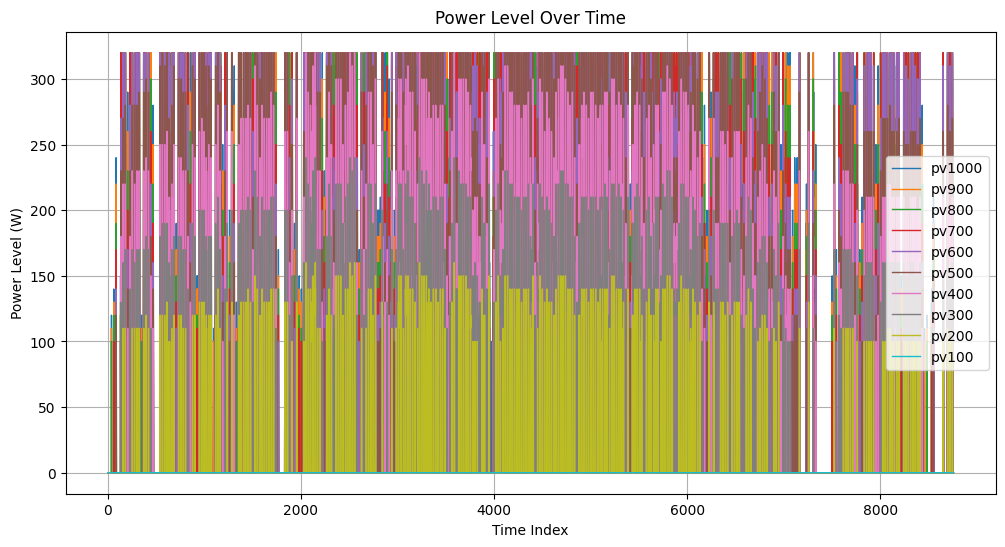

In [12]:
# plot the running list
plt.figure(figsize=(12, 6))
# Get all keys in correct order (smallest to largest)
keys = sorted(pvs.keys(), key=lambda x: int(x[2:]))
# Plot in reverse order so smaller PVs are on bottom
for i in range(len(running_list_max)-1, -1, -1):
    plt.plot(running_list_max[i], label=keys[i], linewidth=1)
    
plt.xlabel('Time Index')
plt.ylabel('Power Level (W)')
plt.title('Power Level Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
print(running_list_max)
print(running_list_max.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(10, 8760)


### for each area setting of the pv panel, the time required to reach the 1000 epoch is calculated.

#### for the smallest power level to run the 1000 epoch

In [14]:
time_to_run = np.zeros((running_list.shape[0], 2))
# the first column is the index of the PVs
time_to_run[:, 0] = [int(key[2:]) for key in pvs.keys()]

for i in range(running_list.shape[0]):
    time_count = 0
    for j in range(running_list.shape[1]):
        if running_list[i, j] == 100:
            time_count += 1/ epoch100_time[0]
        
        # if the time_count reachs to epoch100_time[0], then break the loop
            if time_count >= 1:
                break
    time_to_run[i, 1] = j

print(time_to_run) 


[[ 100. 8759.]
 [ 200.  542.]
 [ 300.  323.]
 [ 400.  297.]
 [ 500.  278.]
 [ 600.  277.]
 [ 700.  275.]
 [ 800.  250.]
 [ 900.  230.]
 [1000.  229.]]


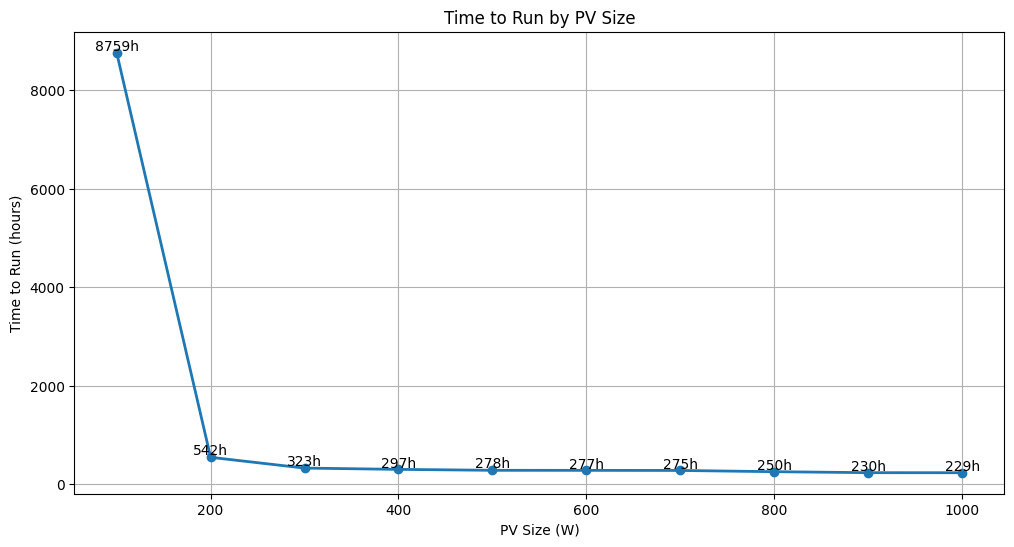

In [15]:
# plot the time to run
plt.figure(figsize=(12, 6))
plt.plot(time_to_run[:, 0], time_to_run[:, 1], marker='o', linewidth=2)
plt.xlabel('PV Size (W)')
plt.ylabel('Time to Run (hours)')
plt.title('Time to Run by PV Size')
plt.grid(True)
# Add markers for data points
for x, y in zip(time_to_run[:, 0], time_to_run[:, 1]):
    plt.text(x, y+50, f'{int(y)}h', ha='center')
plt.show()

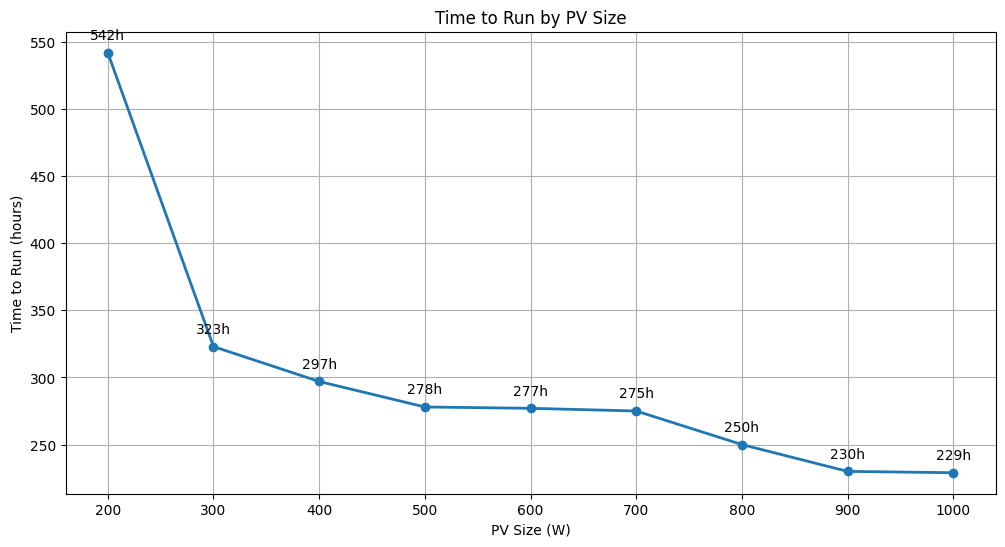

In [16]:
# plot the time to run
plt.figure(figsize=(12, 6))
plt.plot(time_to_run[1:, 0], time_to_run[1:, 1], marker='o', linewidth=2)
plt.xlabel('PV Size (W)')
plt.ylabel('Time to Run (hours)')
plt.title('Time to Run by PV Size')
plt.grid(True)
# Add markers for data points
for x, y in zip(time_to_run[1:, 0], time_to_run[1:, 1]):
    plt.text(x, y+10, f'{int(y)}h', ha='center')
plt.show()

#### for the highest power level that it could reach to run the 1000 epoch

In [17]:
time_to_run_max = np.zeros((running_list_max.shape[0], 2))
# the first column is the index of the PVs
time_to_run_max[:, 0] = [int(key[2:]) for key in pvs.keys()]

# create a dictionary to store each PV's avaliable power level
pv_power_level = {}

for i in range(running_list_max.shape[0]):
    panel_level_i = time_to_run_max[i, 0]
    power_level_i_list = []
    time_count = 0
    for j in range(running_list_max.shape[1]):
        # Find the index of current power level in power_level series
        if running_list_max[i, j] > 0:  # if system is running
            power_idx = list(power_level).index(running_list_max[i, j])
            power_level_i_list.append(running_list_max[i, j])
            # print(f'Power level: {running_list_max[i, j]}, time: {epoch100_time[power_idx]}')
            # Add the proportional time (1/epoch100_time[power_idx])
            time_count += 1/epoch100_time[power_idx]
        # if the time_count reachs to epoch100_time[0], then break the loop
        if time_count >= 1:
            break
    # Store the power levels for this panel
    pv_power_level[panel_level_i] = power_level_i_list
        

    time_to_run_max[i, 1] = j

print(time_to_run_max) 
print(pv_power_level)


[[ 100. 8759.]
 [ 200.  539.]
 [ 300.  276.]
 [ 400.  251.]
 [ 500.  231.]
 [ 600.  228.]
 [ 700.  227.]
 [ 800.  182.]
 [ 900.  181.]
 [1000.  180.]]
{100.0: [], 200.0: [110.0, 100.0, 110.0, 100.0, 100.0, 110.0, 110.0, 100.0, 110.0, 100.0, 100.0, 110.0, 110.0, 100.0, 110.0, 110.0, 100.0, 110.0, 100.0, 120.0, 110.0, 110.0, 110.0, 110.0, 110.0], 300.0: [130.0, 160.0, 130.0, 160.0, 170.0, 160.0, 140.0, 140.0, 100.0, 130.0, 160.0, 170.0, 160.0, 140.0, 100.0, 150.0, 160.0], 400.0: [180.0, 120.0, 220.0, 100.0, 170.0, 210.0, 220.0, 210.0, 180.0, 130.0, 110.0, 100.0, 100.0, 180.0, 130.0, 100.0, 170.0, 210.0], 500.0: [120.0, 230.0, 160.0, 270.0, 130.0, 210.0, 260.0, 280.0, 270.0, 230.0, 160.0, 140.0, 130.0, 120.0, 230.0, 160.0], 600.0: [140.0, 270.0, 190.0, 320.0, 150.0, 260.0, 320.0, 320.0, 320.0, 280.0, 190.0, 170.0, 100.0, 160.0, 150.0], 700.0: [100.0, 170.0, 100.0, 320.0, 220.0, 320.0, 180.0, 300.0, 320.0, 320.0, 320.0, 320.0, 220.0, 200.0, 110.0, 180.0], 800.0: [100.0, 120.0, 190.0, 100.0

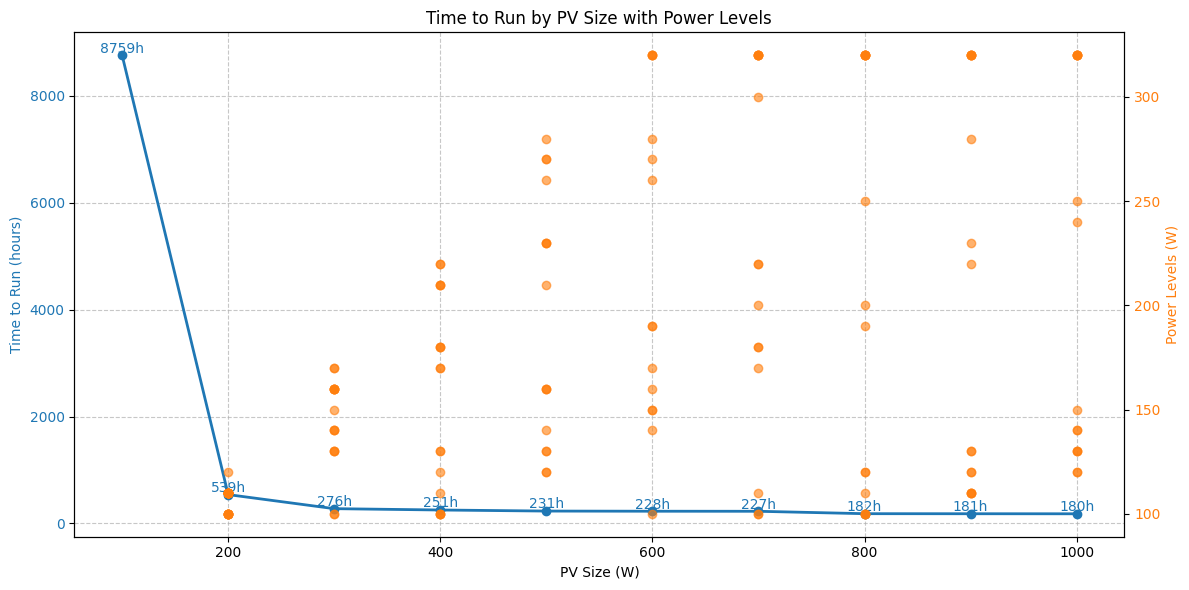

In [28]:
# Create figure and axis objects with a single subplot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot time to run on left y-axis
color = 'tab:blue'
ax1.set_xlabel('PV Size (W)')
ax1.set_ylabel('Time to Run (hours)', color=color)
line1 = ax1.plot(time_to_run_max[:, 0], time_to_run_max[:, 1], marker='o', 
                 linewidth=2, color=color, label='Time to Run')
ax1.tick_params(axis='y', labelcolor=color)

# Add markers for time data points
for x, y in zip(time_to_run_max[:, 0], time_to_run_max[:, 1]):
    ax1.text(x, y+50, f'{int(y)}h', ha='center', color=color)

# Create second y-axis that shares x-axis
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Power Levels (W)', color=color)

# Plot power levels for each PV size with count annotations
for pv_size, levels in pv_power_level.items():
    if levels:  # Only plot if there are power levels
        for power in levels:
            ax2.scatter([pv_size], [power], color=color, alpha=0.6)
            # ax2.text(pv_size, power, str(int(power)), ha='center', va='bottom', color=color)

ax2.tick_params(axis='y', labelcolor=color)

# Add grid
ax1.grid(True, linestyle='--', alpha=0.7)

# Set title
plt.title('Time to Run by PV Size with Power Levels')

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

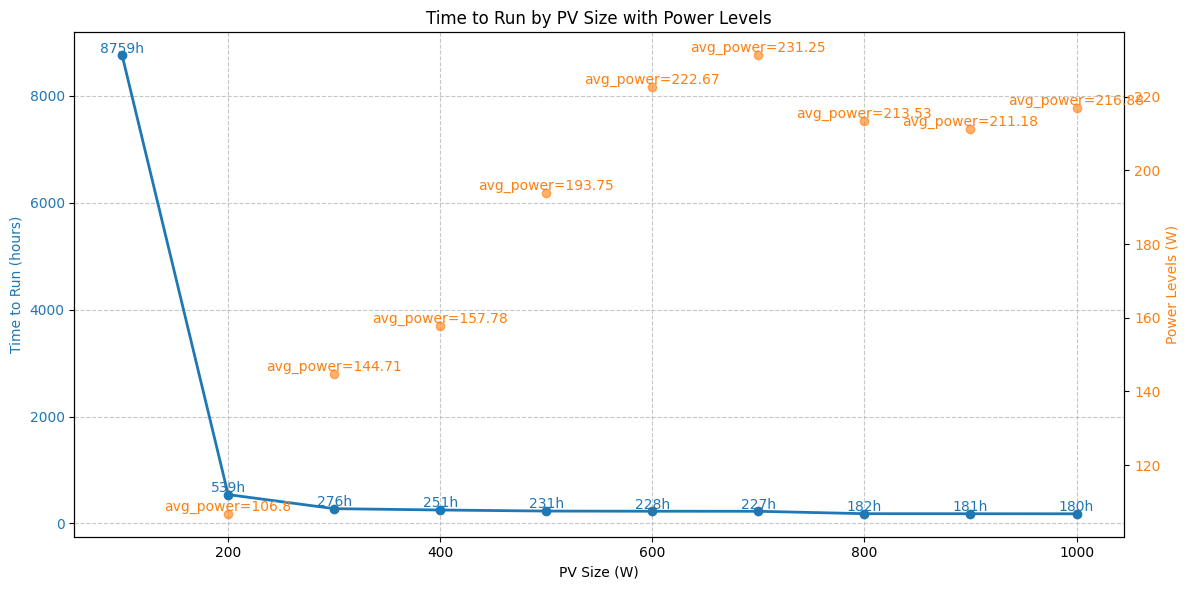

In [27]:
# Create figure and axis objects with a single subplot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot time to run on left y-axis
color = 'tab:blue'
ax1.set_xlabel('PV Size (W)')
ax1.set_ylabel('Time to Run (hours)', color=color)
line1 = ax1.plot(time_to_run_max[:, 0], time_to_run_max[:, 1], marker='o', 
                 linewidth=2, color=color, label='Time to Run')
ax1.tick_params(axis='y', labelcolor=color)

# Add markers for time data points
for x, y in zip(time_to_run_max[:, 0], time_to_run_max[:, 1]):
    ax1.text(x, y+50, f'{int(y)}h', ha='center', color=color)

# Create second y-axis that shares x-axis
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Power Levels (W)', color=color)

# Plot power levels for each PV size with count annotations
for pv_size, levels in pv_power_level.items():
    if levels:  # Only plot if there are power levels
        avg_power = sum(levels) / len(levels)
        ax2.scatter([pv_size], [avg_power], color=color, alpha=0.6)
        # ax2.text(pv_size, avg_power, f'n={len(levels)}', 
        #         color=color, ha='center', va='bottom')
        avg_power = round(avg_power, 2)
        ax2.text(pv_size, avg_power, f'avg_power={avg_power}', 
                color=color, ha='center', va='bottom')

ax2.tick_params(axis='y', labelcolor=color)

# Add grid
ax1.grid(True, linestyle='--', alpha=0.7)

# Set title
plt.title('Time to Run by PV Size with Power Levels')

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

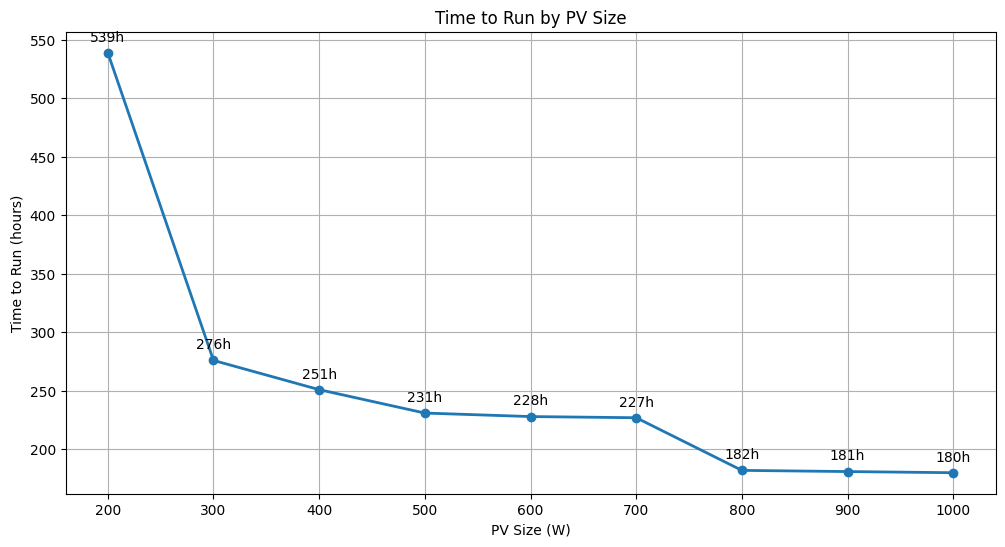

In [19]:
# plot the time to run
plt.figure(figsize=(12, 6))
plt.plot(time_to_run_max[1:, 0], time_to_run_max[1:, 1], marker='o', linewidth=2)
plt.xlabel('PV Size (W)')
plt.ylabel('Time to Run (hours)')
plt.title('Time to Run by PV Size')
plt.grid(True)
# Add markers for data points
for x, y in zip(time_to_run_max[1:, 0], time_to_run_max[1:, 1]):
    plt.text(x, y+10, f'{int(y)}h', ha='center')
plt.show()